# Introduction

## What hedge funds do 

In [1]:
# hide
from IPython.display import Image, display

This material is an introduction to using machine-learning for portfolio management and trading. Given the centrality of programming in hedge funds today, the concepts are exposed using only `jupyter` notebooks in `python`. Moreover, we leverage the `scikit-learn` package (also known as `sklearn`) to illustrate how machine-learning is used in practice in this context. 

As shown by the illustration below, we cover here topics that span Finance (market microstructure, portfolio construction, data, etc), Machine-learning (including mathematics and statistics) and Software engineering/Computer science. 

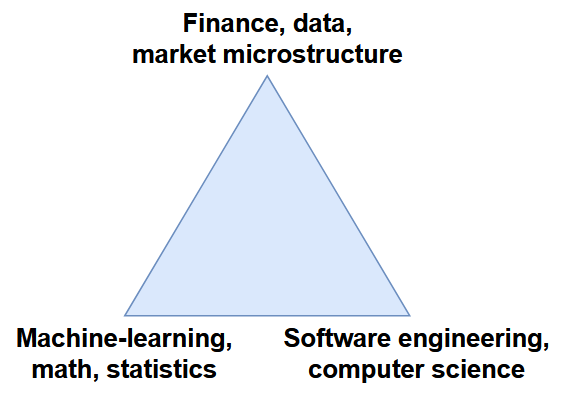

In [2]:
# hide
display(Image("images/ml_triangle.png", width=300))

We are interested in how quantitative hedge funds operate in practice. A hedge fund is an asset management compapny that pools together capital from multiple investors to invest it in a portfolio of securities to maximize returns given a level of risk. Today, quantitative hedge funds are essentially *consumers* of data -- they ingest all sorts of datasets and extract information used to systematically buy or sell securities. Researchers and portfolio managers are deeply involved in the process of `data ingestion` and `information extraction`, but they do not directly decide which securities are bought or sold -- instead algorithms do.

Because these processes of `data ingestion` and `information extraction` are so central to quantitative hedge fund operations, they have become `software companies` -- a lot of the intellectual property (IP) of hedge funds is embedded in the code they write. And in that sense, hedge funds are not so different from other data-science based technology companies. (And in fact the hiring has become very similar, with a lot of interest in profiles out of Computer Science, Machine-Learning, Data engeeniring, Statistics, etc).

Another point is the Hedge Fund industry is very competitive and given that the frontier of knowledge is today moving very quickly (because of active research in Data, ML, hardware, software, etc) not keeping up with progress runs the risk of lagging by the competition. More precisely, innovation implies comming up with new ideas, testing them, deploying these ideas in trading systems; learning from them -- and then deploying newer ideas after that. Of course, this kind of "loop of progress" (see [Francois Chollet (04/03/2019)](https://twitter.com/fchollet/status/1113476428249464833)) is common to all AI-impacted industries. 

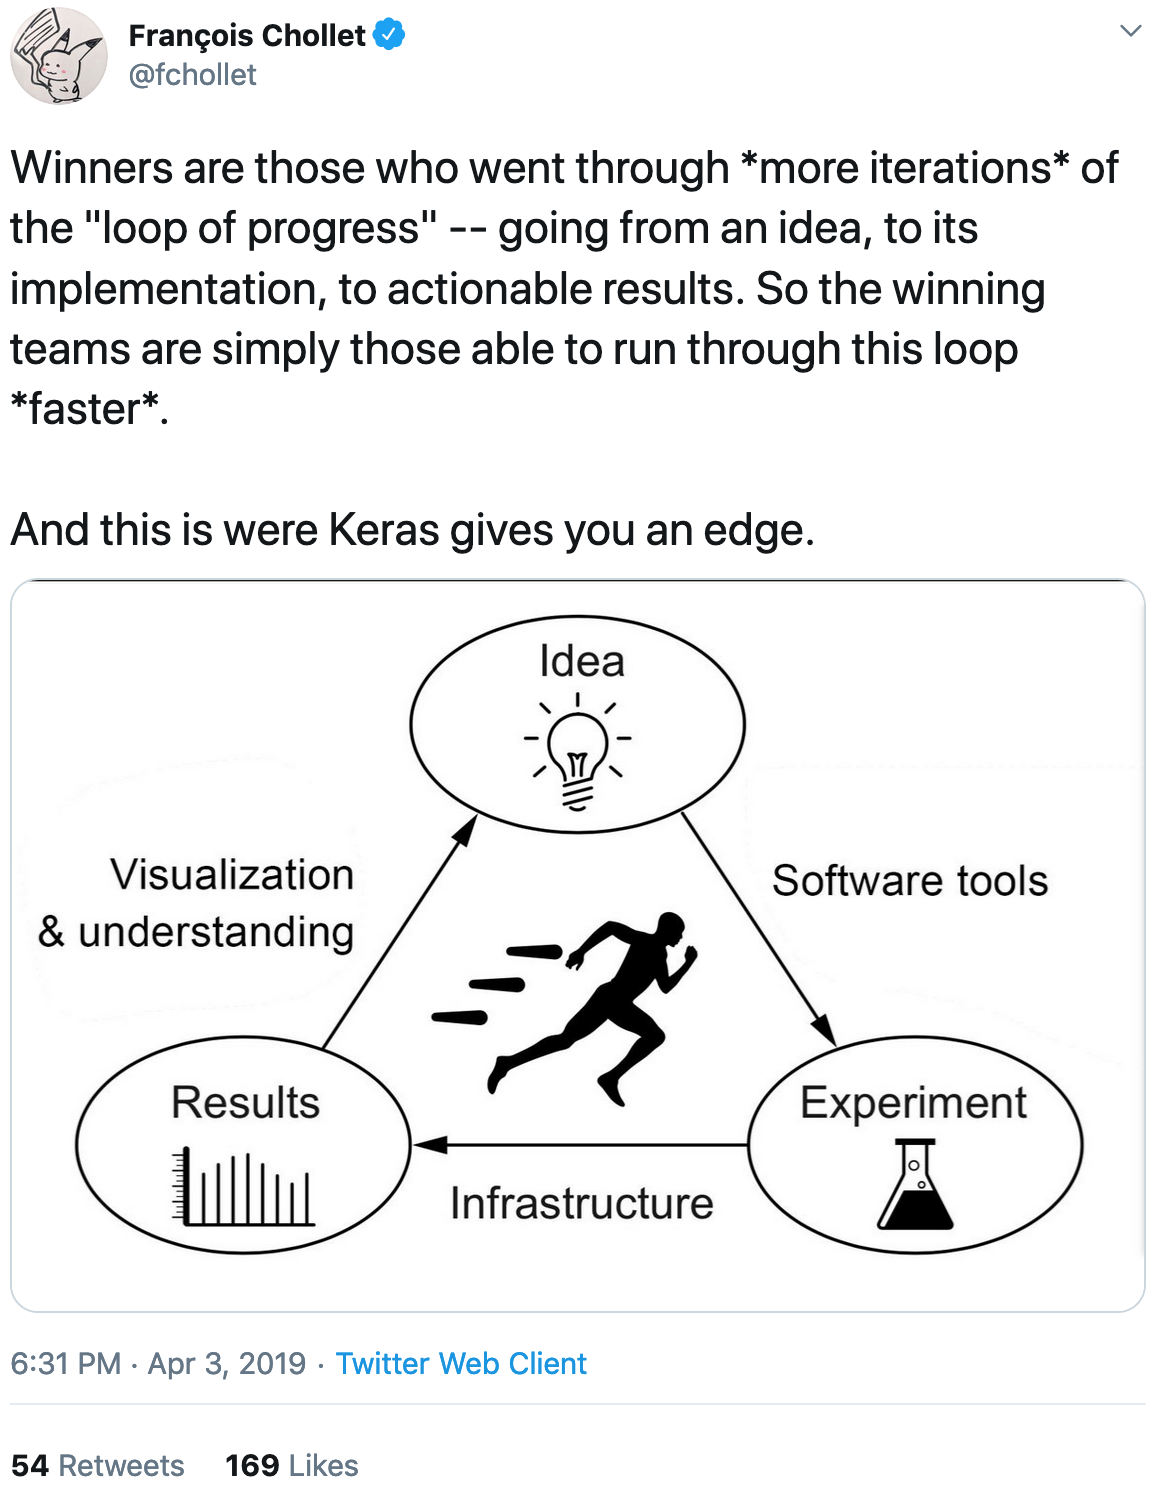

In [3]:
# hide
display(Image("images/kaggle_iterations2.png", width=400))

## Overview

Across notebooks, we cover three main empirical use-cases: timing industry returns; timing stock returns; and timing the market (ie. timing the Standard and Poor's 500 index). For each use-case, there is a set of toy-datasets (described in the `Data` section).

Moreover: 

- for the industry return backtest, we illustrate several main concepts: learning (with linear models, boosted trees, and MLP neural nets); risk; factor exposures; transaction costs; ensemble; 
- for the stock return backtest, we illustrate mean-reversion, trading around corporate events and sentiment (in earning calls); 
- for the market timing backtest, we also illustrate traing around macroeconomic events, and extracting sentiment in the statements of the Federal Open Market Committee (FOMC). 

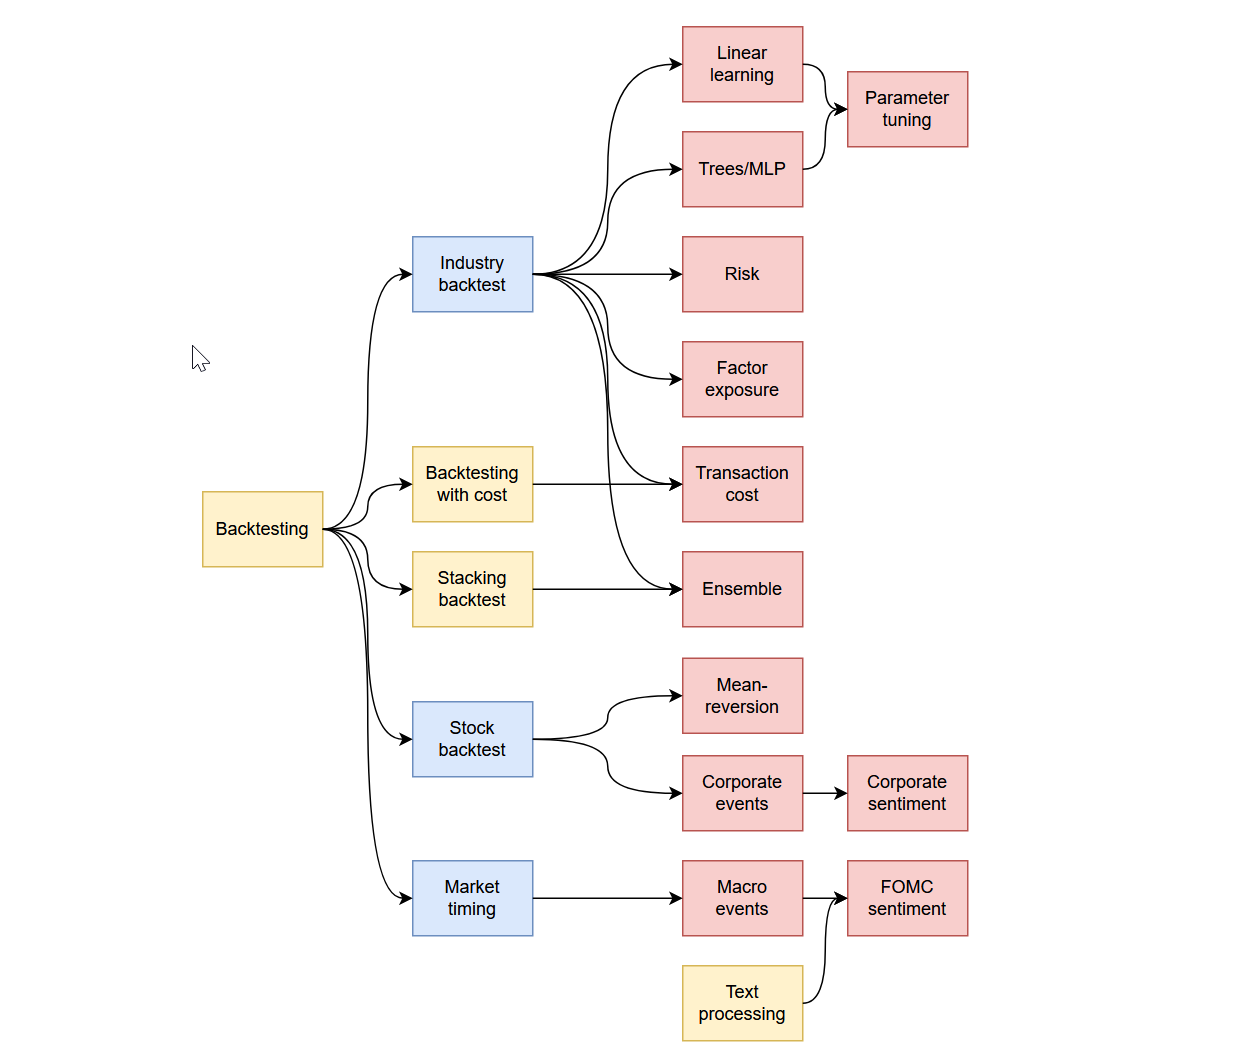

In [4]:
# hide
display(Image("images/book_overview2.png", width=800))

## Quant workflow

The graph below shows the typical data workflow of a quantitative fund: 

- Raw data is acquired generally by a Data team and possibly transformed into usable features. 
- Data quality is checked, in particular that timestamp of each observation is valid and has not been revised in a way that injects future information. 
- From these features, predictors of asset returns are derived. 
- Given a single predictor (or a set of many predictors), porfolios are constructed: these portfolios represent the ideal positions of a fund given the asset forecasts, but also risk forecasts (and possibly, transaction cost forecasts). 
- When these ideal positions change from one day to the next (because the underlying data has been updated), the difference in positions initiate trades that are then executed on asset exchanges or with brokers. 


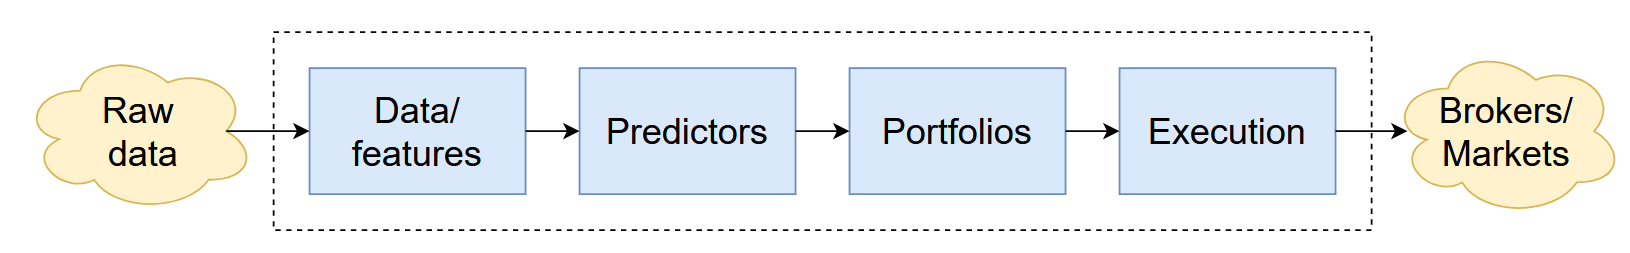

In [5]:
# hide
display(Image("images/quant_workflow.png", width=800))

## MLOps for backtests

MLOps (machine learning operations) represents a set of practices for the deployment of ML models in production. For quant hedge funds, there are two main concepts that we describe here:  

- pipelines 

- backtests 

### Pipelines 

Pipeline: 

> A machine-learning pipeline is an end-to-end description of the automated flow of data from raw inputs to a desired output. Each step represents a transformation of the data, possibly with a fitted model. 


The diagram below illustrates a pipeline for a quant fund. The end point (to the right of the diagram) are the positions or `holdings` in a set of traded securities -- and combined with the returns on these securities, the pnl of a given strategy can be computed. The entry point (to the left of the diagram) are `features`. A set of `transformations` (pre-determined in the `pipeline`) are applied to these `features` to produce the desired `holdings`. Some `transformations` in the `pipeline` are "fixed" while others depend on `fitted models` (e.g. a ML predictor of returns or a risk model). 

In the diagram, we emphasize the timing of these different objects: 

- for a pnl at time $t$, the `features` and `target` include only information up to $t-1$ so that the holdings are known in $t-1$ and can accrue returns over the period $t$. 

The following equation summarizes this point: 

$$ pnl_t = holdings_{t-1} \times returns_t. $$

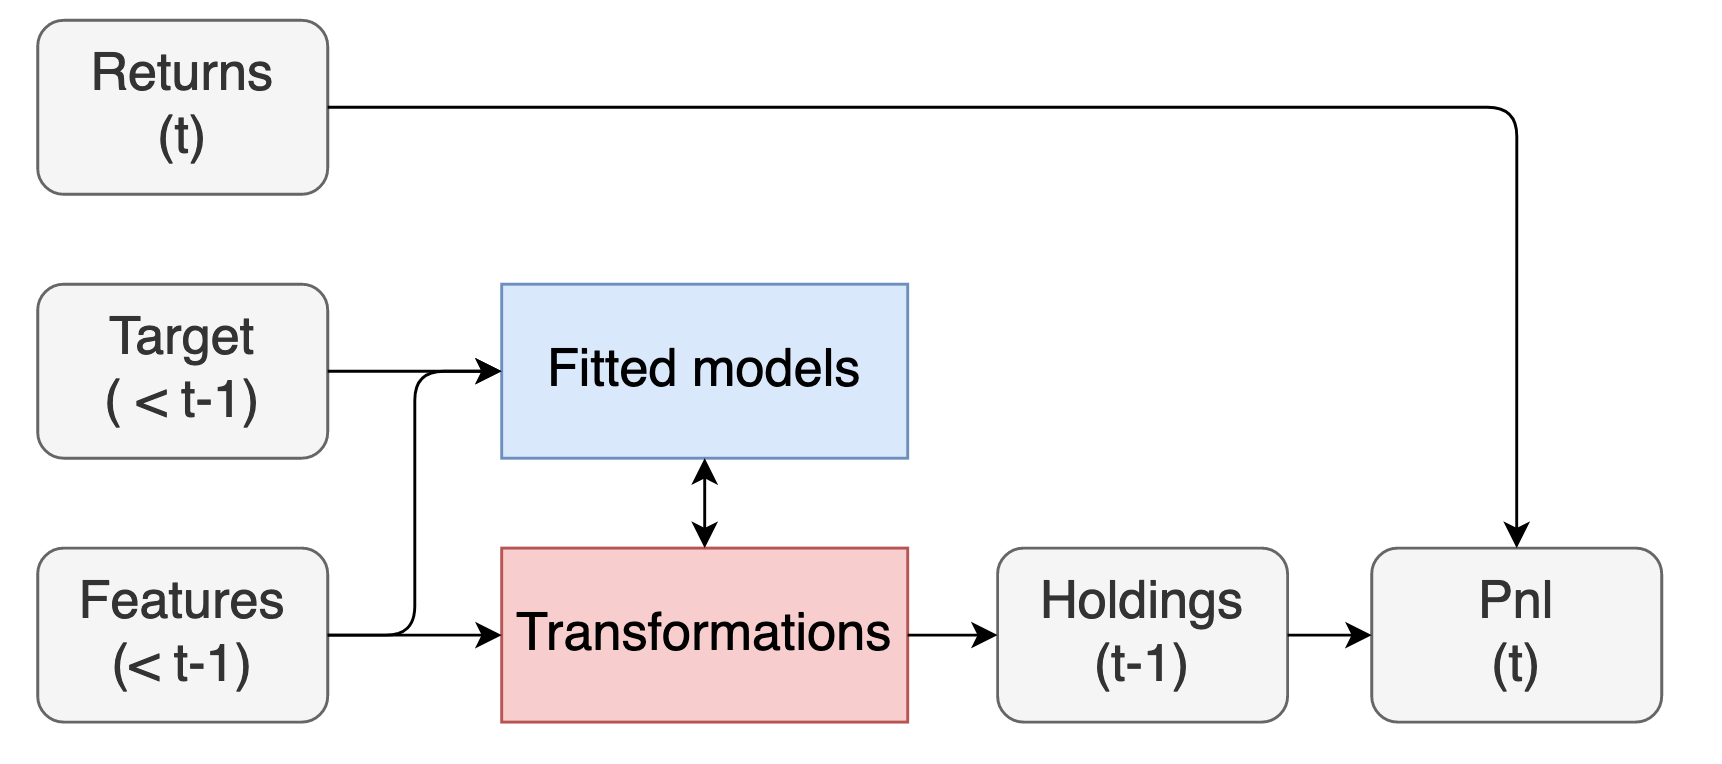

In [6]:
# hide
display(Image("images/ml4pmt_pipeline3.png", width=500))

### Scikit-learn

The following notebooks and notes are largely based on  `scikit-learn`. `scikit-learn` is an extremely powerful (and widely used) package for machine-learning. In particular, it provides a "grammar" for pipelines  where each transformation or estimator class has the `fit`/`transform`/`predict` functions with arguments as (`X`, `y`) where `X` represents the  features and `y`, targets. 

A look-ahead bias occurs when data dated at $t$ includes information only available after $t$; in contrast, point-in-time data ensures that data dated at t is based on only information up to date t. A backtest is a method to simulate a strategy using point-in-time historical data and evaluate its profitability. 

In order to illustrate how to use pipelines à la `scikit-learn` for quantitative portfolio management, we introduce in the next sections two objects: 

- a `Mean-variance` estimator that computes positions from a predictor;
- a `Backtester` class that fits a `scikit-learn` estimator over rolling windows (as defined by the `TimeSeriesSplit` class). 

The `Backtester` class runs the rolling window simulation so that only information up to date $t-1$ is used to determined the holdings at that date. The following graph shows an example of a learning pipeline (with a `StandardScaler` and `Ridge` steps before compute the positions with the `Mean-variance` estimator) that we will use. 

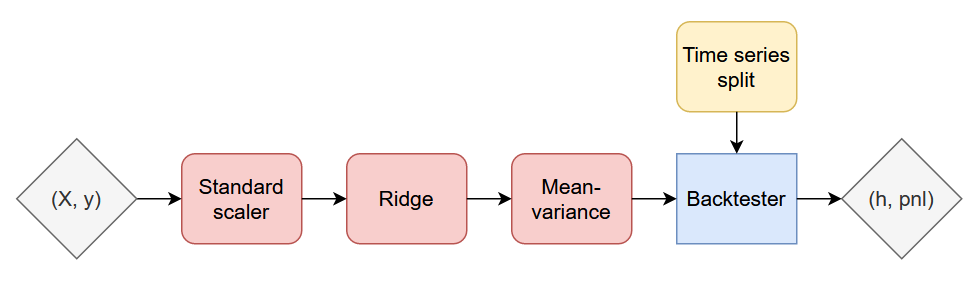

In [7]:
# hide
display(Image("images/ml_pipeline_example.png", width=700))

In [8]:
from skfin import Backtester, MeanVariance, Ridge
from skfin.datasets_ import load_kf_returns
from skfin.plot import line
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

estimator = make_pipeline(StandardScaler(with_mean=False), Ridge(), MeanVariance())

returns_data = load_kf_returns(cache_dir="data")
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]

transform_X = lambda x: x.rolling(12).mean().fillna(0)
transform_y = lambda x: x.shift(-1)
features = transform_X(ret)
target = transform_y(ret)

INFO:skfin.dataloaders.cache:Loading from cache : data/12_Industry_Portfolios


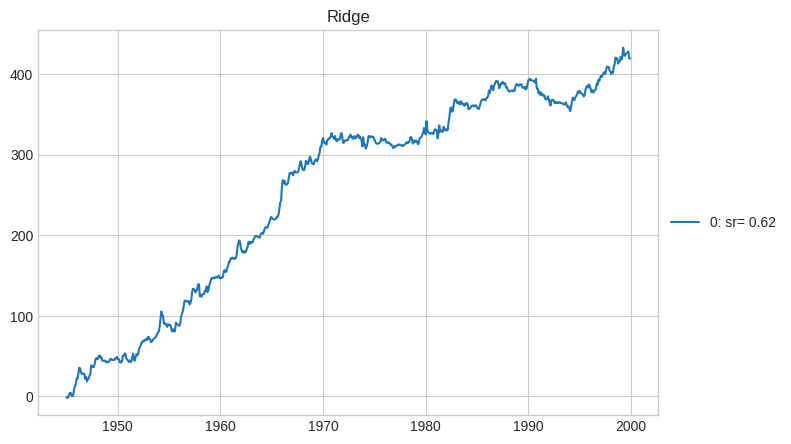

In [9]:
pnl_ = Backtester(estimator).train(features, target, ret)
line(pnl_, cumsum=True, title="Ridge")

The graph above shows the annualized sharpe ratio (as `sr`): given that the strategy is monthly, this is the montly pnl average divided by the monthly pnl standard deviation and "annualized" by multiplying by the square-root of the number of observation per year ($\sqrt{12}$).

## Python package

All the classes and functions used across notebooks are stored in `.py` files using the `jupyter magic`: `%%writefile`. And these files are structured as a repository on `github` that can be cloned from the command line (once in the correct directory):  
> ```git clone https://github.com/schampon/skfin.git && cd skfin```

The following script helps create an environment with the proper packages: 

In [10]:
%%writefile ../create_env.sh
conda create python=3.9 --name  skfin -c https://conda.anaconda.org/conda-forge/ -y
conda activate skfin

pip install -r requirements.txt
pip install -e . 
python -m ipykernel install --user --name skfin --display-name "Python (skfin)"

Overwriting ../create_env.sh


In practice, this is done from the command line with: 
    
> ``` ./create_env.sh ```